### MLP Eğitimi

Bu notebook da mlp modeli eğitilmiştir. En iyi veri seti filtrelenmiş veri setidir. Bu nedenle sadece onunla deneyler gerçekleştirilmiştir. Over-fitting i önlemek için 5-fold cross validation kullanılmıştır.

Denenen MLP parametreleri:

| Parametre | Model 1 | Model 2 | Model 3 | Model 4 |
|-----------|---------|---------|---------|---------|
| hidden_layer_sizes | (200, 100) | (200, 100) | (150, 100, 50) | (150, 100, 50) |
| activation | relu | tanh | relu | tanh |
| solver | adam | adam | adam | adam |
| max_iter | 2000 | 2000 | 2000 | 2000 |
| learning_rate_init | 0.01 | 0.01 | 0.01 | 0.01 |
| batch_size | 128 | 128 | 128 | 128 |
| early_stopping | True | True | True | True |

### En iyi model parametreleri:
| Parametre | Değer |
|-----------|-------|
| hidden_layer_sizes | (200, 100) |
| activation | tanh |
| solver | adam |
| max_iter | 2000 |
| learning_rate_init | 0.01 |
| batch_size | 128 |
| early_stopping | True |


### En iyi model sonuçları:

CV Sonuçları
| | Accuracy | Precision | Recall | F1 Score |
|-----------------|----------|-----------|--------|----------|
| Ortalama | 0.9751 | 0.9695 | 0.9635 | 0.9665 |
| Standart Sapma | 0.0036 | 0.0012 | 0.0100 | 0.0051 |

Test Sonuçları
| | Accuracy | Precision | Recall | F1 Score |
|-------------|----------|-----------|--------|----------|
| Değer | 0.9798 | 0.9716 | 0.9746 | 0.9731 |

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import mlflow

def plot_and_log_confusion_matrix(y_true, y_pred, title, filename, figsize=(10,8)):
    """
    Confusion matrix oluşturur, görselleştirir ve MLflow'a kaydeder
    """
    # Confusion matrix hesapla
    cm = confusion_matrix(y_true, y_pred)
    
    tn, fp, fn, tp = cm.ravel()
    
    plt.figure(figsize=figsize)
    
    sns.heatmap(cm, 
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=['Güvenli', 'Oltalama'],
                yticklabels=['Güvenli', 'Oltalama'])
    
    plt.title(title)
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek')
    
    plt.savefig(filename)
    mlflow.log_artifact(filename)
    
    # Confusion matrix metriklerini MLflow'a kaydet
    mlflow.log_metrics({
        f"{title}_true_negatives": tn,
        f"{title}_false_positives": fp,
        f"{title}_false_negatives": fn,
        f"{title}_true_positives": tp
    })
    
    plt.show()
    
    # Metrikleri yazdır
    print(f"\n{title}")
    print(f"True Negatives (Güvenli doğru tahmin): {tn}")
    print(f"False Positives (Güvenli yanlış tahmin): {fp}")
    print(f"False Negatives (Oltalama yanlış tahmin): {fn}")
    print(f"True Positives (Oltalama doğru tahmin): {tp}")

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import mlflow
import mlflow.sklearn
import joblib
import os


def train_and_evaluate_mlp(train_data, test_data, dataset_name,
                          experiment_name, out_dir, mlp_params, text_column='email_text'):
    """
    MLP modelini eğitir, değerlendirir ve sonuçları kaydeder.
    """
    # MLflow deneyini ayarla
    try:
        experiment = mlflow.get_experiment_by_name(experiment_name)
        if experiment is None:
            mlflow.create_experiment(experiment_name)
        mlflow.set_experiment(experiment_name)
    except Exception as e:
        print(f"MLflow ayarlanırken hata oluştu: {e}")
    
    # En iyi TF-IDF parametreleri
    tfidf_params = {
        'max_features': 5000,
        'ngram_range': (1, 2)
    }
    
    best_test_f1 = 0
    best_model = None
    best_vectorizer = None
    best_params = None

    os.makedirs(out_dir, exist_ok=True)
    for params in mlp_params:
        with mlflow.start_run(run_name=f"MLP_{dataset_name}_{params['hidden_layer_sizes']}"):
            pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(**tfidf_params)),
                ('mlp', MLPClassifier(**params))
            ])
            
            cv_scores = cross_validate(pipeline, 
                                     train_data[text_column], 
                                     train_data['label'],
                                     cv=5,
                                     scoring=['accuracy', 'precision', 'recall', 'f1'])
            
            # Tüm train verisiyle eğit
            pipeline.fit(train_data[text_column], train_data['label'])
            
            test_pred = pipeline.predict(test_data[text_column])
            
            cv_metrics = {
                'cv_accuracy_mean': cv_scores['test_accuracy'].mean(),
                'cv_accuracy_std': cv_scores['test_accuracy'].std(),
                'cv_precision_mean': cv_scores['test_precision'].mean(),
                'cv_precision_std': cv_scores['test_precision'].std(),
                'cv_recall_mean': cv_scores['test_recall'].mean(),
                'cv_recall_std': cv_scores['test_recall'].std(),
                'cv_f1_mean': cv_scores['test_f1'].mean(),
                'cv_f1_std': cv_scores['test_f1'].std()
            }
            
    
            
            test_metrics = {
                'test_accuracy': accuracy_score(test_data['label'], test_pred),
                'test_precision': precision_score(test_data['label'], test_pred),
                'test_recall': recall_score(test_data['label'], test_pred),
                'test_f1': f1_score(test_data['label'], test_pred)
            }
            
            # MLflow'a parametreleri ve metrikleri kaydet
            mlflow.log_params({
                "dataset": dataset_name,
                **params,
                **tfidf_params
            })
            
            # En iyi modeli güncelle
            if test_metrics['test_f1'] > best_test_f1:
                best_test_f1 = test_metrics['test_f1']
                best_model = pipeline['mlp']
                best_vectorizer = pipeline['tfidf']
                best_params = params

            
            plot_and_log_confusion_matrix(
                test_data['label'],
                test_pred,
                'Test Seti Confusion Matrix',
                os.path.join(out_dir, f"test_confusion_matrix_{params['hidden_layer_sizes']}.png")
            )
            
            # Sonuçları yazdır
            print(f"\nModel parametreleri: {params}")
            print("\nCV metrikleri:")
            for metric, value in cv_metrics.items():
                print(f"{metric}: {value:.4f}")
        
            print(f"\nTest metrikleri:")
            for metric, value in test_metrics.items():
                print(f"{metric}: {value:.4f}")
    
   
    model_path = os.path.join(out_dir, f"{dataset_name}_mlp.joblib")
    vectorizer_path = os.path.join(out_dir, f"{dataset_name}_tfidf.joblib")
    
    joblib.dump(best_model, model_path)
    joblib.dump(best_vectorizer, vectorizer_path)
    
    print(f"\nEn iyi model kaydedildi:")
    print(f"Model: {model_path}")
    print(f"Vectorizer: {vectorizer_path}")
    print(f"En iyi parametreler: {best_params}")
    
    return best_model, best_vectorizer


In [2]:
import pandas as pd
import os

# Veri setleri yüklenir
data_dir = os.path.join(os.path.dirname(os.getcwd()), "source", "data")

filtered_train_data = pd.read_csv(os.path.join(data_dir, "filtered_train.csv"))
filtered_test_data = pd.read_csv(os.path.join(data_dir, "filtered_test.csv"))
print(f"filtered train data shape: {filtered_train_data.shape}")
print(f"filtered test data shape: {filtered_test_data.shape}")



filtered train data shape: (14353, 5)
filtered test data shape: (2630, 4)


In [8]:
mlp_params = [
    # (200, 100) hidden layer
    {'hidden_layer_sizes': (200, 100), 'activation': 'relu', 'solver': 'adam', 'max_iter': 2000,
     'learning_rate_init': 0.01, 'batch_size': 128, 'early_stopping': True},
     
    {'hidden_layer_sizes': (200, 100), 'activation': 'tanh', 'solver': 'adam', 'max_iter': 2000,
     'learning_rate_init': 0.01, 'batch_size': 128, 'early_stopping': True},
     
    # (150, 100, 50) hidden layer
    {'hidden_layer_sizes': (150, 100, 50), 'activation': 'relu', 'solver': 'adam', 'max_iter': 2000,
     'learning_rate_init': 0.01, 'batch_size': 128, 'early_stopping': True},
     
    {'hidden_layer_sizes': (150, 100, 50), 'activation': 'tanh', 'solver': 'adam', 'max_iter': 2000,
     'learning_rate_init': 0.01, 'batch_size': 128, 'early_stopping': True}
]

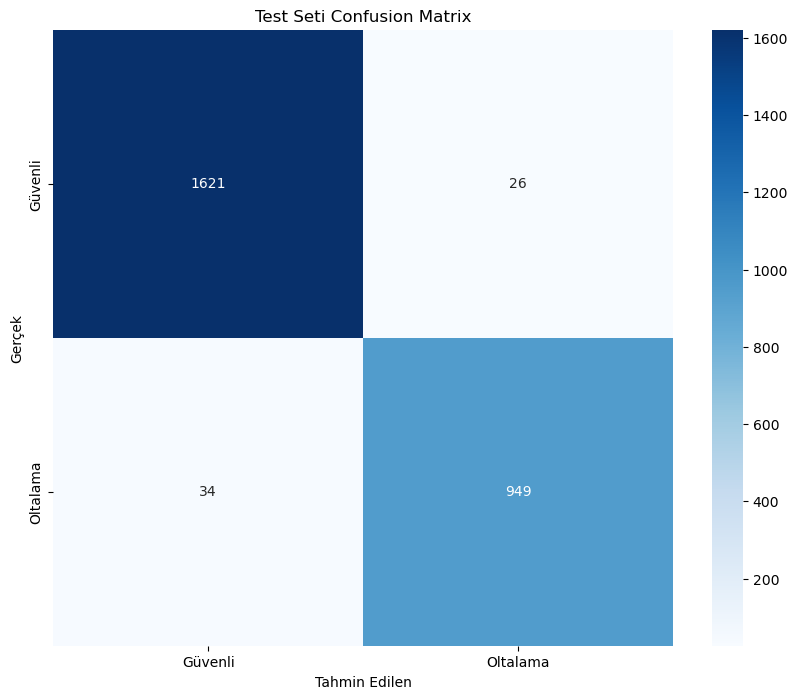


Test Seti Confusion Matrix
True Negatives (Güvenli doğru tahmin): 1621
False Positives (Güvenli yanlış tahmin): 26
False Negatives (Oltalama yanlış tahmin): 34
True Positives (Oltalama doğru tahmin): 949

Model parametreleri: {'hidden_layer_sizes': (200, 100), 'activation': 'relu', 'solver': 'adam', 'max_iter': 2000, 'learning_rate_init': 0.01, 'batch_size': 128, 'early_stopping': True}

CV metrikleri:
cv_accuracy_mean: 0.9758
cv_accuracy_std: 0.0026
cv_precision_mean: 0.9729
cv_precision_std: 0.0092
cv_recall_mean: 0.9618
cv_recall_std: 0.0039
cv_f1_mean: 0.9673
cv_f1_std: 0.0033

Test metrikleri:
test_accuracy: 0.9772
test_precision: 0.9733
test_recall: 0.9654
test_f1: 0.9694


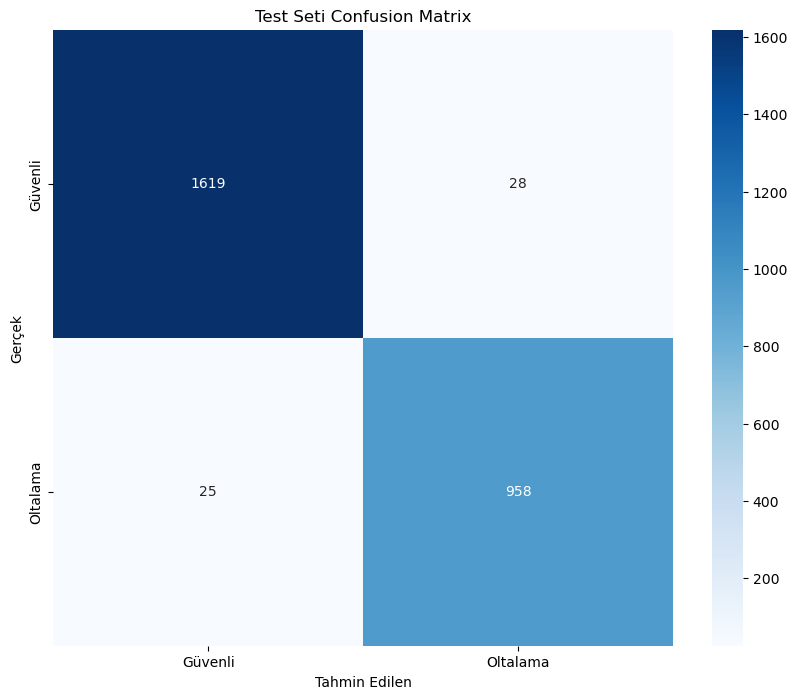


Test Seti Confusion Matrix
True Negatives (Güvenli doğru tahmin): 1619
False Positives (Güvenli yanlış tahmin): 28
False Negatives (Oltalama yanlış tahmin): 25
True Positives (Oltalama doğru tahmin): 958

Model parametreleri: {'hidden_layer_sizes': (200, 100), 'activation': 'tanh', 'solver': 'adam', 'max_iter': 2000, 'learning_rate_init': 0.01, 'batch_size': 128, 'early_stopping': True}

CV metrikleri:
cv_accuracy_mean: 0.9751
cv_accuracy_std: 0.0036
cv_precision_mean: 0.9695
cv_precision_std: 0.0012
cv_recall_mean: 0.9635
cv_recall_std: 0.0100
cv_f1_mean: 0.9665
cv_f1_std: 0.0051

Test metrikleri:
test_accuracy: 0.9798
test_precision: 0.9716
test_recall: 0.9746
test_f1: 0.9731


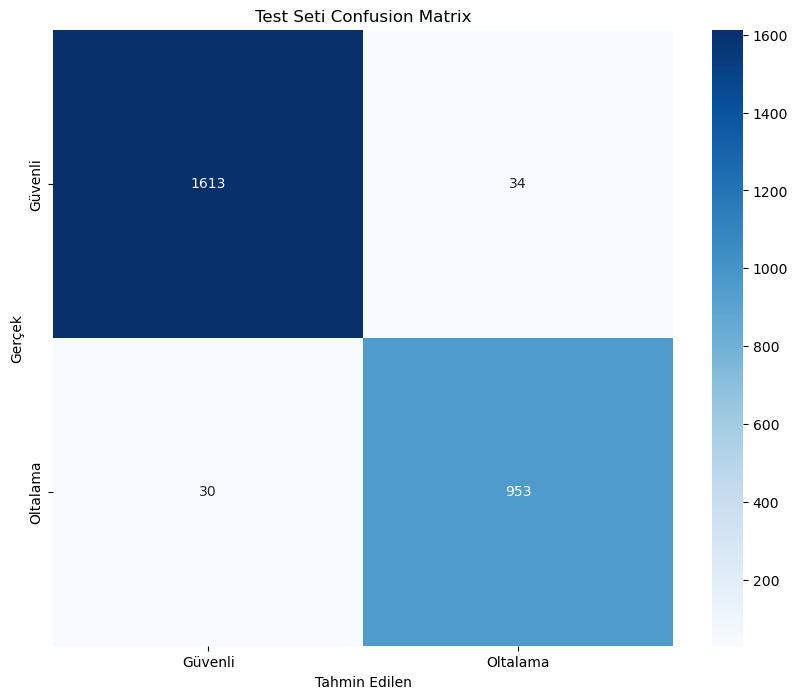


Test Seti Confusion Matrix
True Negatives (Güvenli doğru tahmin): 1613
False Positives (Güvenli yanlış tahmin): 34
False Negatives (Oltalama yanlış tahmin): 30
True Positives (Oltalama doğru tahmin): 953

Model parametreleri: {'hidden_layer_sizes': (150, 100, 50), 'activation': 'relu', 'solver': 'adam', 'max_iter': 2000, 'learning_rate_init': 0.01, 'batch_size': 128, 'early_stopping': True}

CV metrikleri:
cv_accuracy_mean: 0.9776
cv_accuracy_std: 0.0016
cv_precision_mean: 0.9680
cv_precision_std: 0.0046
cv_recall_mean: 0.9719
cv_recall_std: 0.0073
cv_f1_mean: 0.9699
cv_f1_std: 0.0023

Test metrikleri:
test_accuracy: 0.9757
test_precision: 0.9656
test_recall: 0.9695
test_f1: 0.9675


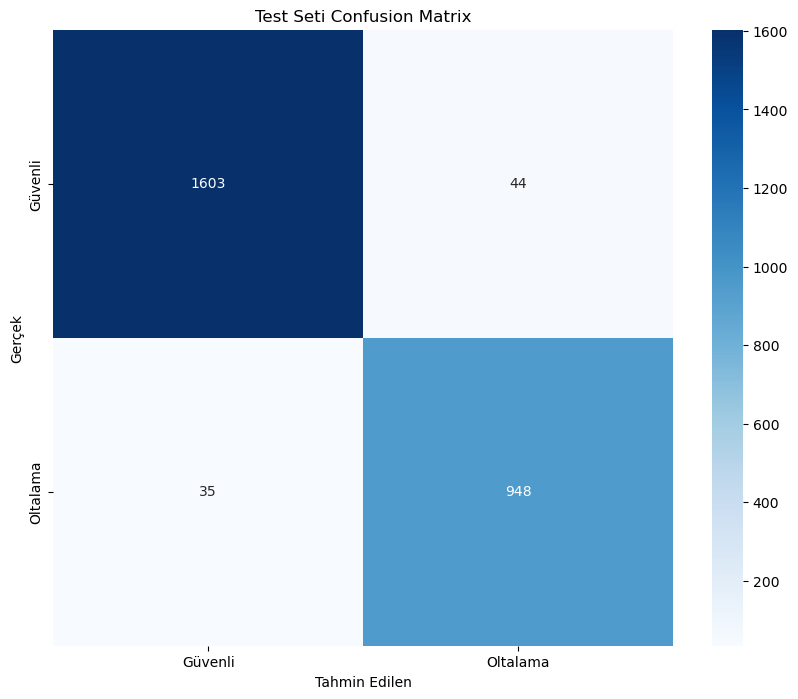


Test Seti Confusion Matrix
True Negatives (Güvenli doğru tahmin): 1603
False Positives (Güvenli yanlış tahmin): 44
False Negatives (Oltalama yanlış tahmin): 35
True Positives (Oltalama doğru tahmin): 948

Model parametreleri: {'hidden_layer_sizes': (150, 100, 50), 'activation': 'tanh', 'solver': 'adam', 'max_iter': 2000, 'learning_rate_init': 0.01, 'batch_size': 128, 'early_stopping': True}

CV metrikleri:
cv_accuracy_mean: 0.9732
cv_accuracy_std: 0.0032
cv_precision_mean: 0.9711
cv_precision_std: 0.0080
cv_recall_mean: 0.9568
cv_recall_std: 0.0119
cv_f1_mean: 0.9638
cv_f1_std: 0.0045

Test metrikleri:
test_accuracy: 0.9700
test_precision: 0.9556
test_recall: 0.9644
test_f1: 0.9600

En iyi model kaydedildi:
Model: /Users/tczeuslu/Desktop/zgu/courses/data_mining/phishing-mail-detection/src/source/models/mlp/filtered_mlp.joblib
Vectorizer: /Users/tczeuslu/Desktop/zgu/courses/data_mining/phishing-mail-detection/src/source/models/mlp/filtered_tfidf.joblib
En iyi parametreler: {'hidden_lay

In [9]:
model_dir = os.path.join(os.path.dirname(os.getcwd()),"source", "models", "mlp")
# Modeli eğit
best_model, best_vectorizer = train_and_evaluate_mlp(
    train_data=filtered_train_data,
    test_data=filtered_test_data,
    dataset_name="filtered",
    experiment_name="MLP-experiments",
    out_dir=model_dir,
    mlp_params=mlp_params
)